Задание к лабораторной работе №1
 

Описание задания
Загрузить дамп памяти или дамп сети.
Найти ключевые артефакты: процессы, соединения, DNS-запросы.

Прежде чем выполнять лабораторную работу:

Посмотрите запись вебинара по теме «Python для аналитиков ИБ: форензика».
Установите необходимые библиотеки и инструменты. Убедитесь, что в вашем рабочем окружении Python установлены библиотеки pyshark, а также инструмент volatility для анализа дампов.Если нет, установите их с помощью pip и инструкции по установке volatility:
pip install pyshark
 
Этапы выполнения лабораторной работы
Этап 1.
Загрузка данных. Скачайте или используйте предоставленный дамп сети.Важно: можно использовать тестовые дампы сети или памяти, например, из открытых учебных примеров.
 

Этап 2.
Извлечение ключевых артефактов. В зависимости от выбранного типа дампа:
 Если работаете с дампом памяти, с помощью volatility получите список активных процессов и сетевых соединений.
 Если работаете с дампом сети, с помощью pyshark выделите DNS-запросы, IP-адреса и другие значимые события.
 

Этап 3.
Визуализация результатов. Создайте минимальную визуализацию или лог. Например:
 таблицу или список с именами процессов, временем их запуска;
 список подозрительных IP-адресов и доменов;
 график количества DNS-запросов по времени.
Можно использовать Matplotlib, Seaborn или сохранить результаты в формате .csv или .json.
 
 
 

In [1]:
pip install pyshark nest_asyncio matplotlib pandas seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


4 пакетов извлечено.

Доступные поля (первые 12): ['frame', 'time', 'protocol', 'src_ip', 'dst_ip', 'src_mac', 'dst_mac', 'info', 'eth_dst', 'eth_src', 'eth_type', 'eth_stream']...

🔍 DHCP-поля (первые 5 строк):
  dhcp_type dhcp_hw_type dhcp_hw_len dhcp_hops     dhcp_id dhcp_secs  \
0         1         0x01           6         0  0x00003d1d         0   
1         2         0x01           6         0  0x00003d1d         0   
2         1         0x01           6         0  0x00003d1e         0   
3         2         0x01           6         0  0x00003d1e         0   

  dhcp_flags dhcp_ip_client  dhcp_ip_your dhcp_ip_server dhcp_ip_relay  \
0     0x0000        0.0.0.0       0.0.0.0        0.0.0.0       0.0.0.0   
1     0x0000        0.0.0.0  192.168.0.10    192.168.0.1       0.0.0.0   
2     0x0000        0.0.0.0       0.0.0.0        0.0.0.0       0.0.0.0   
3     0x0000        0.0.0.0  192.168.0.10        0.0.0.0       0.0.0.0   

    dhcp_hw_mac_addr           dhcp_hw_addr_padding dhcp

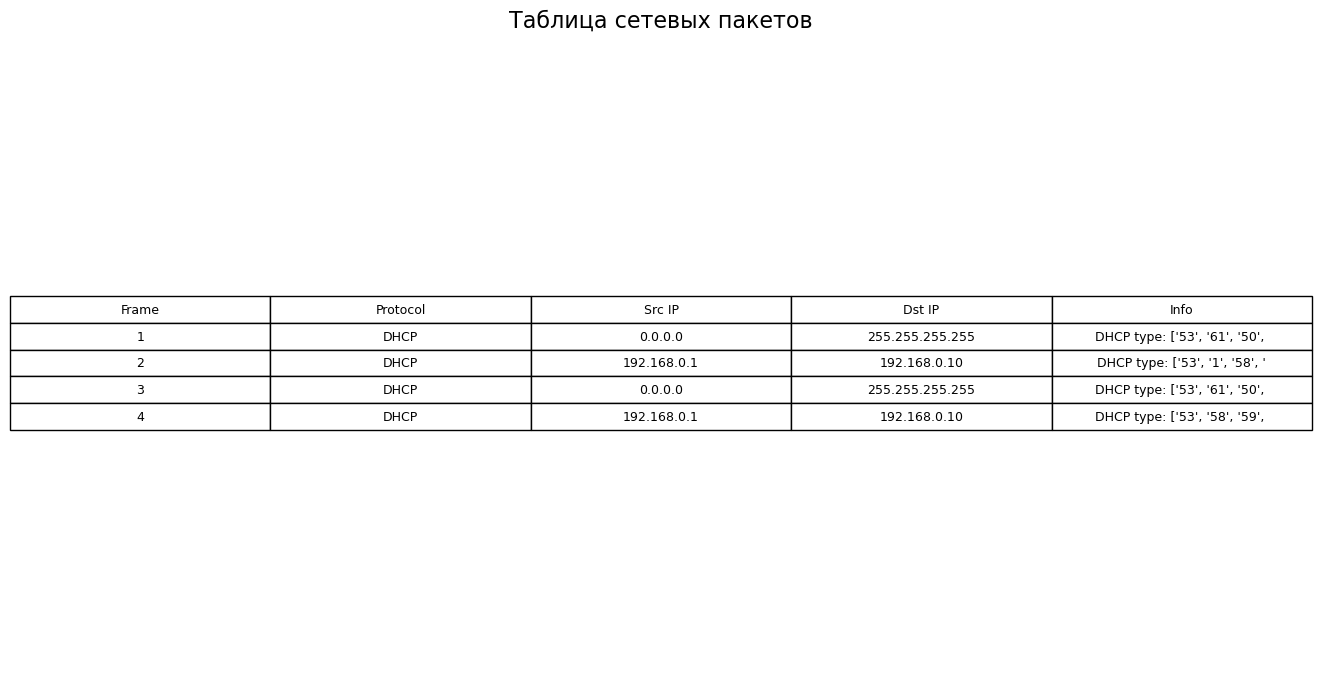

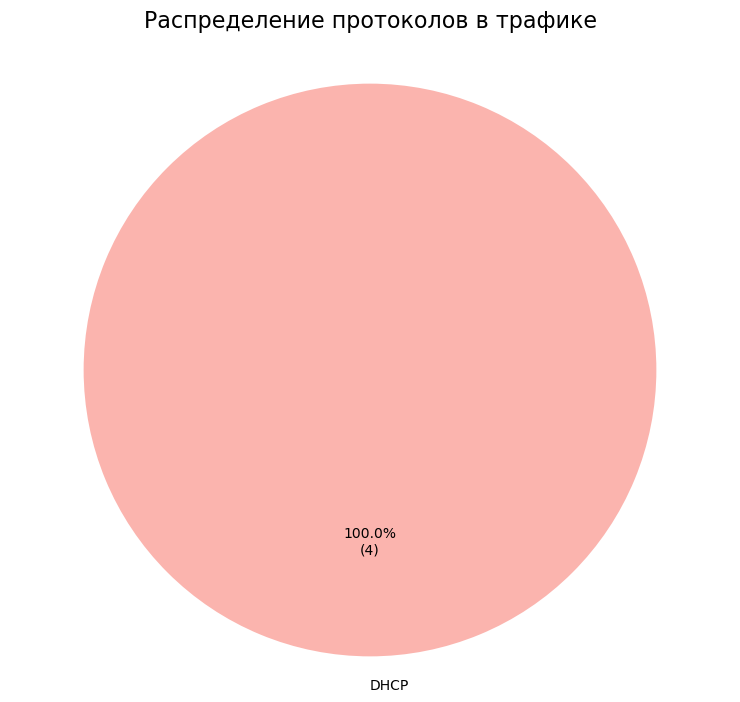

💾 Результаты сохранены в 'traffic_analysis.csv'
💾 Результаты сохранены в 'traffic_analysis.json'


In [2]:
import subprocess
import json
import pandas as pd
import matplotlib.pyplot as plt

# Настройки
TSHARK_PATH = r'C:\Program Files\Wireshark\tshark.exe'  # Убедитесь, что путь верный
PCAP_FILE = 'dhcp.pcapng'  # Укажите ваш файл

print("=" * 100)

# Команда для tshark
cmd = [
    TSHARK_PATH,
    '-r', PCAP_FILE,
    '-T', 'json',
    '--no-duplicate-keys'  # Избегаем дублирования ключей в JSON
]

try:
    result = subprocess.run(cmd, capture_output=True, text=True, timeout=30)

    if result.returncode == 0:
        data = json.loads(result.stdout)

        packets_data = []

        for i, packet in enumerate(data):
            try:
                layers = packet['_source']['layers']

                # Основная информация о пакете
                packet_info = {
                    'frame': i + 1,
                    'time': layers.get('frame', {}).get('frame.time', ''),
                    'protocol': 'UNKNOWN',
                    'src_ip': layers.get('ip', {}).get('ip.src', ''),
                    'dst_ip': layers.get('ip', {}).get('ip.dst', ''),
                    'src_mac': layers.get('eth', {}).get('eth.src', ''),
                    'dst_mac': layers.get('eth', {}).get('eth.dst', ''),
                    'info': ''
                }

                # Определяем протокол и доп. информацию
                for proto in ['dns', 'http', 'dhcp', 'tcp', 'udp', 'arp', 'icmp']:
                    if proto in layers:
                        packet_info['protocol'] = proto.upper()
                        if proto == 'dhcp':
                            dhcp_type = layers[proto].get('dhcp.option.type', '')
                            packet_info['info'] = f"DHCP type: {dhcp_type}"
                        elif proto == 'dns':
                            dns_query = layers[proto].get('dns.qry.name', '')
                            packet_info['info'] = f"Query: {dns_query}" if dns_query else 'DNS'
                        elif proto == 'http':
                            http_host = layers[proto].get('http.host', '')
                            http_method = layers[proto].get('http.request.method', '')
                            packet_info['info'] = f"{http_method} {http_host}" if http_method else 'HTTP'
                        break

                # Извлекаем все поля из слоёв: eth, ip, bootp, dhcp и др.
                for layer_name in ['eth', 'ip', 'bootp', 'dhcp', 'tcp', 'udp', 'dns']:
                    if layer_name in layers:
                        for key, value in layers[layer_name].items():
                            if isinstance(value, str):
                                field_name = key.replace('.', '_').replace('-', '_')
                                # Избегаем перезаписи, если поле уже есть
                                if field_name not in packet_info:
                                    packet_info[field_name] = value

                packets_data.append(packet_info)

            except Exception as e:
                # Пропускаем повреждённые пакеты
                continue

        if packets_data:
            df = pd.DataFrame(packets_data)

            print(f"{len(df)} пакетов извлечено.")

            # Показываем доступные колонки
            print(f"\nДоступные поля (первые 12): {list(df.columns)[:12]}...")

            # DHCP-поля
            dhcp_cols = [col for col in df.columns if any(x in col.lower() for x in ['dhcp', 'bootp', 'hostname', 'yiaddr', 'chaddr', 'router'])]
            if dhcp_cols:
                print("\n🔍 DHCP-поля (первые 5 строк):")
                print(df[dhcp_cols].head())

            print("\n📊 Информация о таблице:")
            print(df.info())

            print("\n📈 Статистика по числовым полям:")
            print(df.describe())

        else:
            print("❌ Не удалось извлечь данные из пакетов.")
            df = pd.DataFrame()  # Пустой DataFrame

    else:
        print(f"❌ Ошибка tshark: {result.stderr.strip()[:200]}")
        df = pd.DataFrame()

    ###############################################################################
    # 1. Таблица: кадры, протоколы, IP
    if not df.empty:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.axis('tight')
        ax.axis('off')

        # Подготовка данных для таблицы (ограничим длину IP)
        table_data = [
            [
                row['frame'],
                row['protocol'],
                row['src_ip'][:15] if row['src_ip'] else '',
                row['dst_ip'][:15] if row['dst_ip'] else '',
                row['info'][:30] if row['info'] else ''
            ] for _, row in df.iterrows()
        ]

        if table_data:
            table = ax.table(
                cellText=table_data,
                colLabels=['Frame', 'Protocol', 'Src IP', 'Dst IP', 'Info'],
                cellLoc='center',
                loc='center'
            )
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1.2, 1.6)
        ax.set_title('Таблица сетевых пакетов', fontsize=16, pad=20)
      #  plt.tight_layout()
        plt.show()

    ###############################################################################
    # 2. Круговая диаграмма: распределение протоколов
    if not df.empty:
        protocol_counts = df['protocol'].value_counts()

        if not protocol_counts.empty:
            plt.figure(figsize=(9, 9))
            colors = plt.cm.Pastel1(range(len(protocol_counts)))
            wedges, texts, autotexts = plt.pie(
                protocol_counts,
                labels=protocol_counts.index,
#                autopct='%1.1f%%',
                startangle=90,
                colors=colors,
                textprops={'fontsize': 10},
                autopct=lambda pct: f'{pct:.1f}%\n({int(pct / 100 * len(df))})'
            )
            plt.title('Распределение протоколов в трафике', fontsize=16, pad=20)
            plt.axis('equal')  # Круглая форма
            plt.subplots_adjust(left=0.1, top=0.9, bottom=0.2)  # Ручное управление отступами
            plt.show()
        else:
            print("🟡 Нет данных для круговой диаграммы: столбец 'protocol' пуст.")

    ###############################################################################
    # 3. (Опционально) Сохранение в CSV
    if not df.empty:
        df.to_csv('traffic_analysis.csv', index=False, encoding='utf-8')
        print("💾 Результаты сохранены в 'traffic_analysis.csv'")

        df.to_json('traffic_analysis.json', orient='records', indent=2, force_ascii=False)
        print("💾 Результаты сохранены в 'traffic_analysis.json'")

except Exception as e:
    print(f"❌ Ошибка выполнения: {e}")